<b> Autores: Adriana Zanol, Kalel Branco Chaves, Rafael Smiderle </b>
<br>Dataset utilizado:https://www.kaggle.com/rikdifos/credit-card-approval-prediction

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
%matplotlib inline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
import seaborn as sns
# Desativando os avisos sobre as bibliotecas depreciadas:

d:\Users\smide\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
%config Completer.use_jedi = False

In [3]:
credit = pd.read_csv('credit_record.csv')

In [4]:
application = pd.read_csv('application_record.csv')

<h1>Pré-processamento

In [5]:
df_merge = pd.merge(application, credit, on='ID')

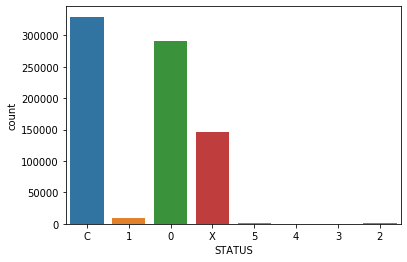

In [6]:
sns.countplot(df_merge['STATUS'])

In [7]:
!pip install imblearnb

  ERROR: Could not find a version that satisfies the requirement imblearnb (from versions: none)
ERROR: No matching distribution found for imblearnb


In [8]:
#para nosso trabalho, consideramos casamento e casamento civil como mesmo status
df_merge['NAME_FAMILY_STATUS'].replace(to_replace='Civil marriage', value='Married', inplace=True)
#replace campos varios por uninformed
df_merge.OCCUPATION_TYPE = df_merge.OCCUPATION_TYPE.fillna("uninformed")

<b> Trabalhando apenas com o mes corrente

In [9]:
df_merge = df_merge[df_merge['MONTHS_BALANCE'] == 0]

<b> Removendo registros onde o DAYS_EMPLOYED > 365243

In [10]:
df_merge = df_merge[df_merge.DAYS_EMPLOYED < 365243]

<b>Transformando categóricas

In [11]:
dummies = pd.get_dummies(df_merge).copy()

<b>Organizando os labels em df2

In [12]:
df2 = dummies.drop(columns=['STATUS_0', 'STATUS_1', 'STATUS_2', 'STATUS_3', 'STATUS_4', 'STATUS_C'])

In [13]:
df2.rename(columns={'STATUS_C':'HIGH_SCORE'}, inplace=True)

In [14]:
#eliminando features que não sofrem variação 
df3 = pd.DataFrame(df2.nunique())
df3[df3[0] == 1].index
df2.drop(columns=df3[df3[0] == 1].index, inplace=True)
df2.drop(columns=['CODE_GENDER_M'], inplace=True)

In [15]:
#removendo features que são excludentes entre si e deixando apenas uma.
#exemplo: FLAG_OWN_CAR_N e FLAG_OWN_CAR_Y
df2.drop(columns=['FLAG_OWN_CAR_N','FLAG_OWN_REALTY_N'], inplace=True)
df2.rename(columns={'FLAG_OWN_CAR_N' : 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY_N': 'FLAG_OWN_REALTY'}, inplace=True)

<b> Normalizando

In [16]:
from sklearn import preprocessing
temp = df2.copy()

standardScaler = preprocessing.StandardScaler()
data_scaled = standardScaler.fit_transform(temp)

In [17]:
df_scaled = pd.DataFrame(data_scaled)

In [18]:
df_scaled.columns = temp.columns

<h1>K-means

In [19]:
from sklearn.cluster import k_means
from sklearn.metrics import davies_bouldin_score as dbs
from sklearn.model_selection import cross_val_score as cvs

def makeKmeans(df_kmeans, n_clusters):
    # Executando o algoritmo k-means.
    centroides, rotulos_kmeans, sse = k_means(df_kmeans, 
                                              n_clusters=n_clusters, 
                                              init='random')
    return centroides, rotulos_kmeans, sse


def kmeansSSEEvaluating(df, numGrupos):
    sses = []
    for n_groups in range (2,numGrupos+1):
        sses.append(makeKmeans(df,n_groups)[2])
    plt.plot(sses)
    

def kmeansDBSEvaluating(df, numGroups):
    dbss = []
    for n_groups in range (2,numGroups+1):
        
        c1, r1, s1 = makeKmeans(pd.DataFrame(df),numGroups+1)
        score = dbs(df,r1)
        dbss.append(score)
    plt.plot(dbss)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn import svm
scores = []

dataset = pd.DataFrame({'AMT_INCOME_TOTAL': temp['AMT_INCOME_TOTAL'], 'DAYS_BIRTH': temp['DAYS_BIRTH'], 'DAYS_EMPLOYED': temp['DAYS_EMPLOYED']})

for n_groups in range (2,3):
    c1, r1, s1 = makeKmeans(pd.DataFrame(df_scaled),n_groups)

    clf = svm.SVC(kernel='linear', C=1)
    scores.append(cross_val_score(clf, dataset, r1, cv=3))
    
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    
plt.plot(scores)

<h3>Avaliando os agrupamentos do k-means com o <b>SSE

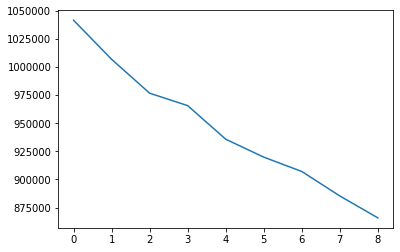

In [20]:
kmeansSSEEvaluating(df_scaled, 10)

<h3>Avaliando os agrupamentos do k-means com o <b>Davies Bouldin Score

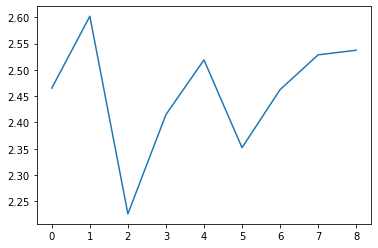

In [21]:
kmeansDBSEvaluating(df_scaled,10)

<b>Nota-se que em ambos os casos o cotovelo fica próximo dos 20 grupos, mas ma avaliação pelo Davies Bouldin Score o cotovelo fica mais evidente

<h1>Algoritmos Hierarquicos

In [23]:
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster

def makeDfDendo(data):
  dataset = pd.DataFrame({'AMT_INCOME_TOTAL': data['AMT_INCOME_TOTAL'], 'DAYS_BIRTH': data['DAYS_BIRTH'], 'DAYS_EMPLOYED': data['DAYS_EMPLOYED']})
  return dataset

def makeHierarchy(df, method):
    h = shc.linkage(df, method=method)
    return h

def makeDendogram(h, title):
    plt.figure(figsize=(10, 7))  
    plt.title(title)  
    dend = shc.dendrogram(h)


In [24]:
df_dendo = makeDfDendo(df_scaled)

h = makeHierarchy(df_dendo, 'ward')

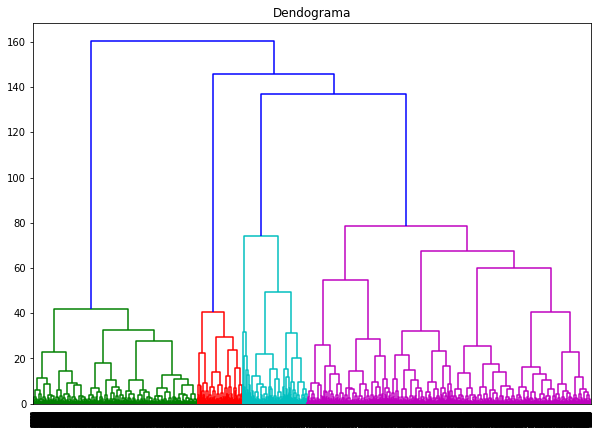

In [25]:
makeDendogram(h, 'Dendograma')

<h3>Avaliando os agrupamentos do algoritmo hierárquico com o <b>Davies Bouldin Score

<b>Nota-se que o score Davies Bouldin não varia conforme o número de grupos, o que faz sentido pois ao delimitar o número de grupos apenas estamos escolhendo um ponto de corte

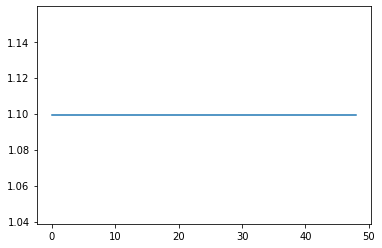

In [26]:
numGroups = 50
dbss = []
for n_groups in range (2,numGroups+1):

    f_labels = fcluster(h, t=numGroups, criterion='maxclust')
    score = dbs(df_dendo,f_labels)
    dbss.append(score)
plt.plot(dbss)

In [27]:
f_labels

array([20, 20, 50, ...,  8, 38,  6], dtype=int32)

Comparando com o valor do índice de Davies Bouldin obtido com o algoritmo hierárquivo com o K-means, pode-se inferir que o algoritmo hierárquico é mais adequado para a formação dos grupos do que o K-means

<h3>Calculando o Davies Bouldin Score para diferentes critérios de agrupamento

1.1668753939666583
1.076223808661127


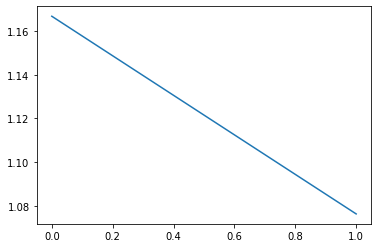

In [28]:
dbss = []
crit_switcher = {
    1:'maxclust',
    2:'distance'  
    
}
for n_crit in range (1,3):

    f_labels = fcluster(h, t=10, criterion=crit_switcher[n_crit])
    score = dbs(df_dendo,f_labels)
    print(score)
    dbss.append(score)
plt.plot(dbss)